In [2]:
import cv2
import imageio
import matplotlib.pyplot as plt
from time import sleep, time, strftime
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle
from random import randint

ModuleNotFoundError: No module named 'cv2'

In [ ]:
!pipenv install cv2

In [3]:
# old video capture source camera (Here webcam of laptop) 
cap = cv2.VideoCapture(0) 
data_list = []

while(True):
    ret, frame = cap.read()
    grey = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(grey, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    
    font = cv2.FONT_HERSHEY_PLAIN    
    cv2.putText(grey, str(len(data_list)), (10,50), font, 3, (0,0,0), 2, cv2.LINE_AA)
    cv2.imshow('frame', grey)
    
    #data_list.append(img/255)
    
    if len(data_list) == 3000 or cv2.waitKey(1) & 0xFF == ord('y'):
        cap.release()
        cv2.destroyAllWindows()
        break

NameError: name 'cv2' is not defined

374


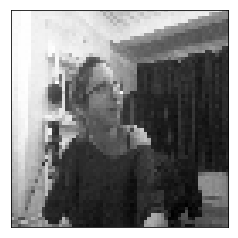

In [12]:
plt.xticks([]), plt.yticks([])
idx = randint(0, len(data_list))
plt.imshow(np.array(data_list[idx]), cmap='gray')
print(idx)

In [14]:
# Save first to disk
izzy = data_list
with open('data_izzy', 'wb') as fp:
    pickle.dump(izzy, fp)

In [3]:
# Save second to disk
ara = data_list
with open('data_ara', 'wb') as fp:
    pickle.dump(ara, fp)

In [15]:
# load the data
with open ('data_izzy', 'rb') as fp:
    izzy = pickle.load(fp)
with open ('data_ara', 'rb') as fp:
    ara = pickle.load(fp)

In [45]:
# prepare data
np_izzy = np.array(izzy)
np_empty = np.array(ara)
y_np_izzy = np.ones(len(np_izzy))
y_np_empty = np.zeros(len(np_empty))

X = np.vstack([np_izzy, np_empty])
y = np.hstack([y_np_izzy, y_np_empty])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

(6000, 2)

1.0


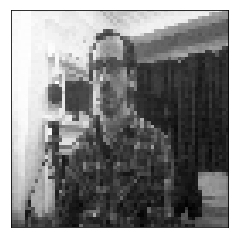

In [24]:
plt.xticks([]), plt.yticks([])
idx = randint(0,X_train.shape[0])
plt.imshow(X_train[idx], cmap='gray')
print(y_train[idx])

### Training the model

In [50]:
# Simple Dense layer NN
model = keras.models.Sequential()

layers = [
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=keras.activations.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation=keras.activations.softmax)
]
for layer in layers:
    model.add(layer)

model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.sparse_categorical_crossentropy ,
              metric=['acc'])

model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Train on 5400 samples, validate on 600 samples
Epoch 1/3
5400/5400 [==============================] - 5s 1ms/step - loss: 0.2224 - val_loss: 0.0272
Epoch 2/3
5400/5400 [==============================] - 5s 856us/step - loss: 0.0155 - val_loss: 0.0059
Epoch 3/3
5400/5400 [==============================] - 4s 814us/step - loss: 0.0065 - val_loss: 0.0025


In [47]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 197us/step


0.0003158653984428383

In [7]:
# need to reshape for the convolutional NN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1],X_test.shape[2], 1)

#one-hot encode target column
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

Using TensorFlow backend.


In [90]:
# Keras
model = keras.models.Sequential()

layers = [
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation=keras.activations.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation=keras.activations.softmax)
]

for layer in layers:
    model.add(layer)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

H = model.fit(X_train_reshaped, y_train_cat, epochs=1, validation_data=(X_test_reshaped, y_test_cat), use_multiprocessing=True)

# save it
model_name = 'CNN - ' + strftime("%Y-%m-%d %H-%M-%S")
model.save(model_name)

Train on 3350 samples, validate on 1650 samples
Epoch 1/1
3350/3350 [==============================] - 75s 22ms/step - loss: 0.2346 - acc: 0.8967 - val_loss: 0.0165 - val_acc: 0.9970


In [ ]:
model.evaluate(X_test_reshaped, y_test_cat)

1.0 [[3.1840348e-06 9.9999678e-01]]


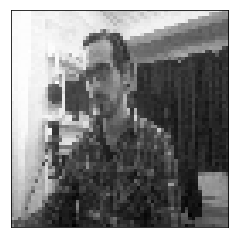

In [37]:
plt.xticks([]), plt.yticks([])
idx = randint(0,X_test.shape[0])
plt.imshow(X_test[idx], cmap='gray')
prediction = model.predict(X_test[idx].reshape(1, 64,64,1))
print(y_test[idx], prediction)

In [51]:
cap = cv2.VideoCapture(0) # video capture source camera (Here webcam of laptop) 

while(True):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    img = cv2.resize(gray, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    np_img = np.array(img)
    resized = (np_img/255).reshape(1, 64,64, 1)
    result = model.predict(resized)
    perc_0 = 'Izzy' if result[0][0] < result[0][1] else 'Ara'
    perc_1 = '{:.1%}'.format(result[0][0])
    perc_2 = '{:.1%}'.format(result[0][1])
    
    # display the captured image
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(frame, f'{perc_0} {perc_1} {perc_2}', (10,50), font, 3, (0,100,100), 2, cv2.LINE_AA)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('y'): # close on pressing 'y' 
        cap.release()
        cv2.destroyAllWindows()
        break

'no'